## Brain Tumor Symptoms Analysis

In [1]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

In [2]:
import warnings

# Your code here

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [3]:
# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [4]:
# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [5]:
# Word2vec
import gensim

In [6]:
# DataFrame
import pandas as pd

In [7]:
# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from keras.utils import to_categorical

In [10]:
# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Raymo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [12]:
# DATASET
DATASET_COLUMNS = ["Statement", "tumor_type"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 200
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
Glioma = "Glioma"
Meningioma = "Meningioma"
Pituitary = "Pituitary"
No_Tumor = "No Tumor"


#SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Datasets

In [13]:
import pandas as pd

# Replace the path with your actual file path
file_path = r"C:\Users\Raymo\Downloads\braintumor2.xlsx"

# Print the file path
print("Open file:", file_path)

# Read Excel file into a pandas DataFrame
df = pd.read_excel(file_path, names=DATASET_COLUMNS)

# Display the DataFrame
df.head()

Open file: C:\Users\Raymo\Downloads\braintumor2.xlsx


,Statement,tumor_type
0,A feeling of disconnection and disorientation ...,Glioma
1,A general feeling of malaise and lethargy,Glioma
2,A general feeling of malaise and lethargy pers...,Glioma
3,A general feeling of malaise and lethargy pers...,Glioma
4,Balance challenges make walking unpredictable,Glioma


In [14]:
print("Dataset size:", len(df))

Dataset size: 515


In [15]:
df.head(5)

,Statement,tumor_type
0,A feeling of disconnection and disorientation ...,Glioma
1,A general feeling of malaise and lethargy,Glioma
2,A general feeling of malaise and lethargy pers...,Glioma
3,A general feeling of malaise and lethargy pers...,Glioma
4,Balance challenges make walking unpredictable,Glioma


### Map target label to String

#### 0 -> Glioma
#### 2 -> Meningioma
#### 4 -> No Tumor
#### 6 -> Pituitary

In [16]:
decode_map = {'Glioma': 0, 'Meningioma': 2, 'No Tumor': 4, 'Pituitary': 6}

def decode_sentiment(label):
    return decode_map.get(label, label)

# Example usage
df['tumor_type'] = df['tumor_type'].apply(lambda x: decode_sentiment(x))

# Print the decode_map dictionary
print("decode_map:", decode_map)

decode_map: {'Glioma': 0, 'Meningioma': 2, 'No Tumor': 4, 'Pituitary': 6}


In [17]:
%%time
df.tumor_type = df.tumor_type.apply(lambda x: decode_sentiment(x))

CPU times: total: 0 ns
Wall time: 1.05 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

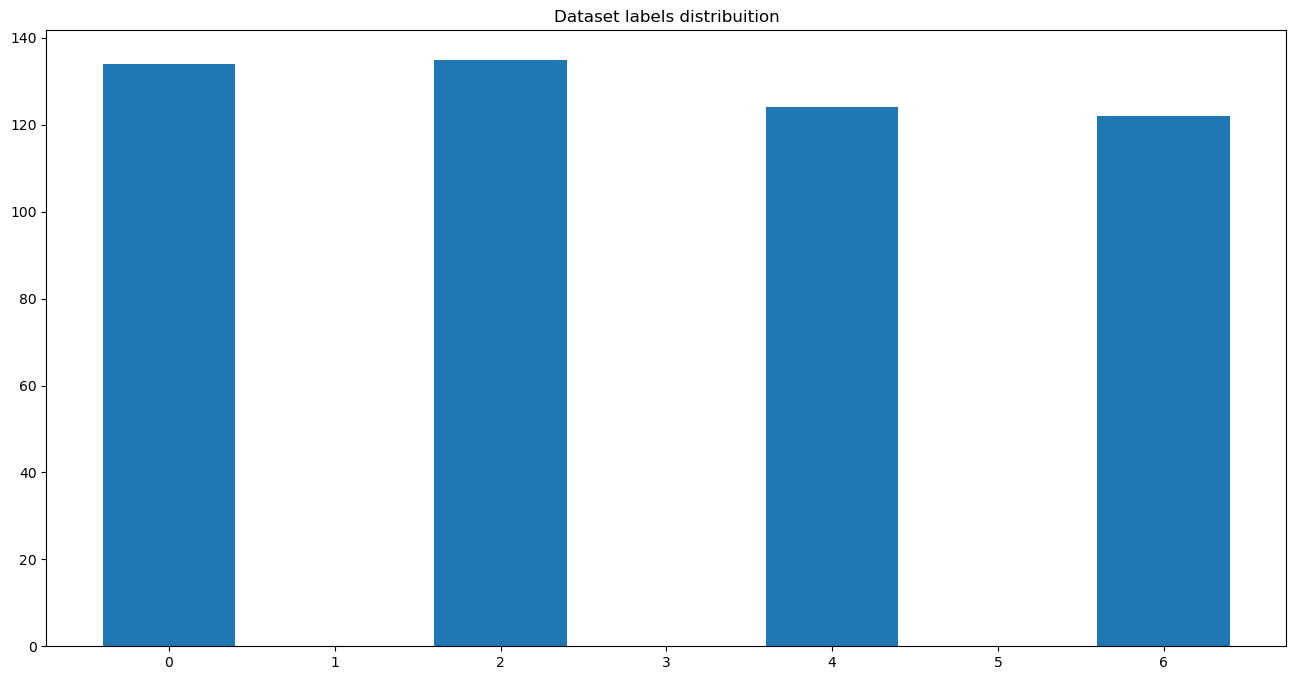

In [18]:
target_cnt = Counter(df.tumor_type)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [19]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [20]:
def preprocess(Statement, stem=False):
    # Remove link,user and special characters
    Statement = re.sub(TEXT_CLEANING_RE, ' ', str(Statement).lower()).strip()
    tokens = []
    for token in Statement.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [21]:
%%time
df.Statement = df.Statement.apply(lambda x: preprocess(x))

CPU times: total: 15.6 ms
Wall time: 19.4 ms


### Split train and test

In [22]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 412
TEST size: 103


### Word2Vec

In [23]:
documents = [_text.split() for _text in df_train.Statement] 

In [24]:
w2v_model = gensim.models.Word2Vec(vector_size=W2V_SIZE, 
                                   window=W2V_WINDOW, 
                                   min_count=W2V_MIN_COUNT, 
                                   workers=8)
###bala

2023-12-18 09:21:05,981 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=200, alpha=0.025>', 'datetime': '2023-12-18T09:21:05.981435', 'gensim': '4.3.2', 'python': '3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'created'}


In [25]:
w2v_model.build_vocab(documents)

2023-12-18 09:21:05,988 : INFO : collecting all words and their counts
2023-12-18 09:21:05,989 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-12-18 09:21:05,991 : INFO : collected 573 word types from a corpus of 2572 raw words and 412 sentences
2023-12-18 09:21:05,993 : INFO : Creating a fresh vocabulary
2023-12-18 09:21:05,995 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 60 unique words (10.47% of original 573, drops 513)', 'datetime': '2023-12-18T09:21:05.995065', 'gensim': '4.3.2', 'python': '3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'prepare_vocab'}
2023-12-18 09:21:05,996 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 leaves 1073 word corpus (41.72% of original 2572, drops 1499)', 'datetime': '2023-12-18T09:21:05.996105', 'gensim': '4.3.2', 'python': '3.11.5 | packaged by Anaconda, Inc. | (main, S

In [26]:
words = w2v_model.wv.index_to_key
vocab_size = len(words)
print("Vocab size:", vocab_size)

Vocab size: 60


In [27]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2023-12-18 09:21:06,019 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 60 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2023-12-18T09:21:06.019449', 'gensim': '4.3.2', 'python': '3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'train'}
2023-12-18 09:21:06,028 : INFO : EPOCH 0: training on 2572 raw words (309 effective words) took 0.0s, 182927 effective words/s
2023-12-18 09:21:06,036 : INFO : EPOCH 1: training on 2572 raw words (333 effective words) took 0.0s, 218218 effective words/s
2023-12-18 09:21:06,043 : INFO : EPOCH 2: training on 2572 raw words (320 effective words) took 0.0s, 231884 effective words/s
2023-12-18 09:21:06,051 : INFO : EPOCH 3: training on 2572 raw words (317 effective words) took 0.0s, 134522 effective words/s
2023-12-18 09:21:06,061 : INFO : EPOCH 4: training on 2572 r

CPU times: total: 62.5 ms
Wall time: 284 ms


(10031, 82304)

In [28]:
vocab = w2v_model.wv.index_to_key
print("Vocabulary:", vocab)

Vocabulary: ['changes', 'difficulty', 'episodes', 'increased', 'feeling', 'daily', 'tasks', 'normal', 'activities', 'discomfort', 'sleep', 'headaches', 'patterns', 'affecting', 'familiar', 'vision', 'foods', 'issues', 'without', 'limbs', 'muscle', 'loss', 'signs', 'sensitivity', 'occasional', 'emotional', 'body', 'conversations', 'leading', 'stable', 'visual', 'appetite', 'noticeable', 'fatigue', 'hair', 'difficulties', 'temperature', 'weakness', 'certain', 'taste', 'good', 'remains', 'words', 'balance', 'consistent', 'speech', 'objects', 'pressure', 'growth', 'preferences', 'especially', 'excessive', 'recent', 'events', 'challenges', 'skin', 'confusion', 'aversions', 'frustration', 'weight']


In [29]:
word_to_check = "difficulty"

if word_to_check in w2v_model.wv:
    similar_words = w2v_model.wv.similar_by_word(word_to_check)
    print(f"Similar words to '{word_to_check}': {similar_words}")
else:
    print(f"Word '{word_to_check}' not present in vocabulary.")

Similar words to 'difficulty': [('changes', 0.8795807957649231), ('episodes', 0.8693052530288696), ('foods', 0.8336740136146545), ('hair', 0.8305745720863342), ('remains', 0.8292046785354614), ('excessive', 0.8269023299217224), ('aversions', 0.8161885142326355), ('taste', 0.8152176141738892), ('consistent', 0.8106952905654907), ('body', 0.8080564737319946)]


### Tokenize Text

In [30]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.Statement)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 574
CPU times: total: 15.6 ms
Wall time: 9.5 ms


In [31]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.Statement), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.Statement), maxlen=SEQUENCE_LENGTH)

CPU times: total: 0 ns
Wall time: 12.4 ms


### Label Encoder

In [32]:
labels = df_train.tumor_type.unique().tolist()
labels.append(No_Tumor)
labels

[4, 2, 6, 0, 'No Tumor']

In [33]:
encoder = LabelEncoder()
encoder.fit(df_train.tumor_type.tolist())

y_train = encoder.transform(df_train.tumor_type.tolist())
y_test = encoder.transform(df_test.tumor_type.tolist())

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (412, 1)
y_test (103, 1)


In [34]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (412, 300)
y_train (412, 1)

x_test (103, 300)
y_test (103, 1)


In [35]:
y_train[:10]

array([[2],
       [2],
       [1],
       [2],
       [3],
       [1],
       [1],
       [2],
       [0],
       [3]], dtype=int64)

### Embedding Layer

In [36]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(574, 200)


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense

# Define embedding_layer
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=W2V_SIZE,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False
)

# Create the Sequential model
model = Sequential()

# Add layers to the model
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modify the output layer (RECOMEND)
model.add(Dense(len(labels), activation='softmax'))

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ embedding (Embedding)              │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout (Dropout)                  │ ?                             │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ lstm (LSTM)                        │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense (Dense)                      │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_1 (Dense)                    │ ?                             │ 0 (unbuilt) │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Build Model

In [38]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ embedding (Embedding)              │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_1 (Dropout)                │ ?                             │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ lstm_1 (LSTM)                      │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_2 (Dense)                    │ ?                             │ 0 (unbuilt) │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Compile Model

In [39]:
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [40]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', mode='max', min_delta=1e-4, patience=5)]

### Train

In [41]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8


C:\Users\Raymo\anaconda3\Lib\site-packages\keras\src\losses\losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2784 - loss: 0.0000e+00 - val_accuracy: 0.2619 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/8


C:\Users\Raymo\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2595 - loss: 0.0000e+00 - val_accuracy: 0.2619 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2595 - loss: 0.0000e+00 - val_accuracy: 0.2619 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2595 - loss: 0.0000e+00 - val_accuracy: 0.2619 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2595 - loss: 0.0000e+00 - val_accuracy: 0.2619 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2595 - loss: 0.0000e+00 - val_accuracy: 0.2619 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2595 - loss: 0.0000e+00 - val_accuracy: 0.2619 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 8/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2595 - loss: 0.0000e+0

In [42]:
model.save('nama model.keras')

### Evaluate

In [43]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.2718 - loss: 0.0000e+00

ACCURACY: 0.27184465527534485
LOSS: 0.0
CPU times: total: 172 ms
Wall time: 287 ms


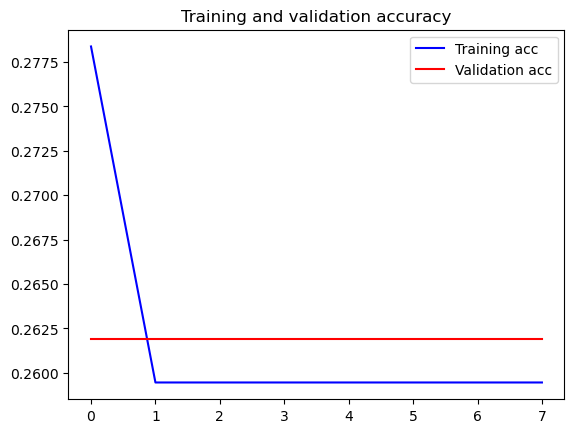

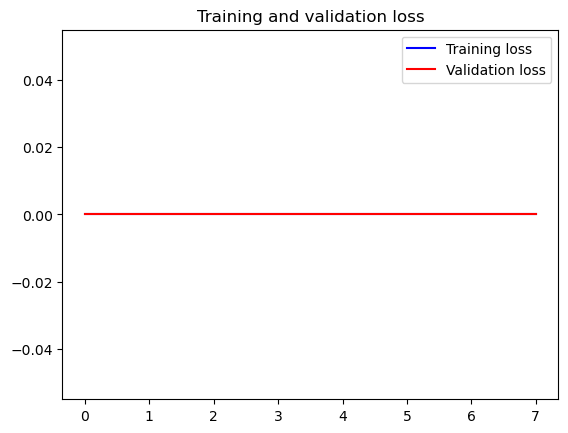

In [44]:
acc = history.history['accuracy']  # Change 'acc' to 'accuracy'
val_acc = history.history['val_accuracy']  # Change 'val_acc' to 'val_accuracy'
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict 

In [68]:
# Adjusted threshold values for each category
Glioma_THRESHOLD = 0.94
Meningioma_THRESHOLD = 0.93
Pituitary_THRESHOLD = 0.92
No_Tumor_THRESHOLD = 0.91  # Adjusted threshold for "No Tumor"

# Adjusted SENTIMENT_THRESHOLDS array
ADJUSTED_SENTIMENT_THRESHOLDS = (Glioma_THRESHOLD, Meningioma_THRESHOLD, Pituitary_THRESHOLD, No_Tumor_THRESHOLD)

def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        if score <= ADJUSTED_SENTIMENT_THRESHOLDS[0]:
            label = "Glioma"
        elif score <= ADJUSTED_SENTIMENT_THRESHOLDS[1]:
            label = "Meningioma"
        elif score <= ADJUSTED_SENTIMENT_THRESHOLDS[2]:
            label = "Pituitary"
        elif score <= ADJUSTED_SENTIMENT_THRESHOLDS[3]:
            label = "No Tumor"
        else:
            label = "Undefined Category"  # You can handle cases where the score doesn't fall into any category

        return label
    else:
        # Adjust thresholds for each category
        if score < 0.90:
            return "Glioma"
        elif score < 0.91:
            return "Meningioma"
        elif score < 0.92:
            return "Pituitary"
        elif score < 0.93:
            return "No"
        else:
            label = "Undefined Category"  # You can handle cases where the score doesn't fall into any category

        # Adjust category based on a higher threshold score
        if score > 0.95:
            label = "High Confidence " + label

        return label


In [69]:
def decode_tumor_category(score):
    return labels[np.argmax(score)]

def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode tumor category
    category = decode_tumor_category(score)

    return {"category": category, "score": float(score[np.argmax(score)]),
            "elapsed_time": time.time() - start_at}
